In [2]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions_offshore import *

import datetime

pandas version is 1.0.1


In [3]:
# Functions for optimization (i.e producing random parametric combination)
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

In [4]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Parameters.xlsx')
x2 = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


In [5]:
# 3. Offshore system - data:
#   a. Read data and parameters
# Import offshore data into df4
df4 = x2.parse('Offshore')

In [6]:
T = []
for i in df4['Sample'][:]:
    T1 = df4['Timeh'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'T'] = T


df4f = df4[(df4.Stage == 'f')]
df4i = df4[(df4.Stage == 'i')]
df4f = df4f.assign(Ni = df4i.N.values)

df4Reduced = df4f[(np.isnan(df4f.DW) != True)&(df4f.Stage == 'f') & (df4f.Depth == 5) & (df4f.Exp != 1) & (df4f.Period == 'Continuous') & (df4f.Days != 12)]

In [7]:
# c. Build interpolations functions for temperature data

xCTD = pd.ExcelFile('../data/CTDr.xlsx')
dfCTD = xCTD.parse('HaderaCTD',header=None)

dfCTD

,0,1,2,3,4,5,6,7,8,9,10
0,time_ISO8601 [yyyy-mm-ddThh:mm:ss:sss],Year,Month,Day,Time,Date&Time,WaterTemp [degC],Depth [m],Longitude [degrees_east],Latitude [degrees_north,Bot. Depth [m]
1,2019-07-22T00:01:03,2019,07,22,00:01:03,2019-07-22 00:01:03,29.7534,12,1,NaN,NaN
2,2019-07-22T00:11:04,2019,07,22,00:11:04,2019-07-22 00:11:04,29.6921,12,2,NaN,NaN
3,2019-07-22T00:21:03,2019,07,22,00:21:03,2019-07-22 00:21:03,29.7344,12,3,NaN,NaN
4,2019-07-22T00:31:04,2019,07,22,00:31:04,2019-07-22 00:31:04,29.6629,12,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42620,2020-05-12T23:11:03,2020,05,12,23:11:03,2020-05-12 23:11:03,21.6181,12,140,NaN,NaN
42621,2020-05-12T23:21:04,2020,05,12,23:21:04,2020-05-12 23:21:04,21.6203,12,141,NaN,NaN
42622,2020-05-12T23:31:03,2020,05,12,23:31:03,2020-05-12 23:31:03,21.576,12,142,NaN,NaN
42623,2020-05-12T23:41:04,2020,05,12,23:41:04,2020-05-12 23:41:04,21.6585,12,143,NaN,NaN


In [8]:
# I do not understand what this cell is doing: Alex
# isn't it just 

Twater = dfCTD.iloc[1:42624:1][6].values 

# TCTD = dfCTD.iloc[1:42624:1][6]
# Twater = []
# for i in TCTD:
#     #if type(i) == int:
#     #    i = str(i)
#     Twater.append(i)#float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [9]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [10]:
# If T_average is a moving average of 6 days with jumps of 6 days
# then the right way is 
T_average = moving_average(Twater[::6],6)
# T_average = []

# for i in range(1,len(Twater),6):
#     T_average.append(np.mean(Twater[i:i+6:1]))

In [11]:
# plt.plot(moving_average(Twater[1::6],6),'r',alpha=.3)
# plt.plot(T_average,'b',alpha=.2)

In [12]:
# c. Build interpolations functions for temperature and light IMS data
    # 1. Import combined IMS excel for light function
dfims = pd.read_csv('../data/ims.csv',encoding= 'unicode_escape',header=None)
# days = list(range(1,296))
days = np.arange(1,296) # or from day 0? np.arange(296)

I_plot = np.zeros(24*296)
light_hours = np.arange(5,19)
for day in days:
    for hour in light_hours:
        I_plot[(day-1)*24 + hour] = float(dfims.iloc[day][hour-1])


all_hours = np.arange(1,296*24+1)

fI0 = interpolate.interp1d(all_hours, I_plot,kind = 'linear',bounds_error=False, fill_value="extrapolate")

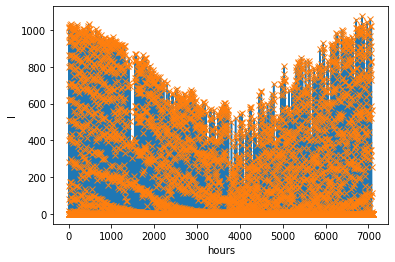

In [13]:
plt.plot(all_hours,fI0(all_hours),all_hours,I_plot,'x')
plt.xlabel('hours')
plt.ylabel('I');

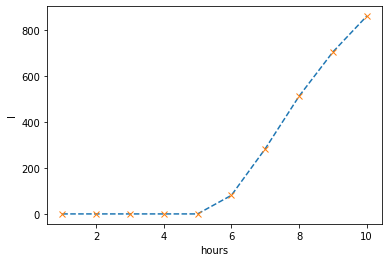

In [14]:
plt.plot(all_hours[:10],fI0(all_hours[:10]),'--',all_hours[:10],I_plot[:10],'x')
plt.xlabel('hours')
plt.ylabel('I');

In [15]:
# 4. Calculate model results for:

In [16]:
df4Reduced

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,TN,DGR,RGR,GR,Treatment,Comment,Comment 2,N_Saturation,T,Ni
62,53.70,2,Continuous,13,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,NaN,0.077470,6.189534,6.385100,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,1.760000
63,54.70,2,Continuous,14,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,NaN,0.177315,11.528773,12.219628,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,NaN
64,55.70,2,Continuous,15,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.063476,0.192143,12.175506,12.947741,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,NaN
65,56.70,2,Continuous,16,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,NaN,0.124470,8.951807,9.364710,NaN,NaN,NaN,no,170,NaN
66,57.70,2,Continuous,17,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,NaN,0.129353,9.210430,9.647918,NaN,NaN,NaN,no,170,NaN
67,58.70,2,Continuous,18,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.039678,0.106246,7.943142,8.267131,NaN,NaN,NaN,no,170,NaN
119,93.70,3,Continuous,13,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.052255,0.069286,NaN,5.811373,NaN,NaN,NaN,no,166,1.193394
120,94.70,3,Continuous,14,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,NaN,0.082143,NaN,6.704550,NaN,NaN,NaN,no,166,NaN
121,95.70,3,Continuous,15,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,NaN,0.082143,NaN,6.704550,NaN,NaN,NaN,no,166,NaN
122,96.70,3,Continuous,16,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,NaN,0.067143,NaN,5.658022,NaN,NaN,NaN,no,166,NaN


In [17]:
# optimized parameters: bounds

problem = {
    'num_vars': 15,
    'names': ['λ20','Nintmax','Nintcrit','Nextlosses','Ks','Vmax','KI','K0','Ka','Smin','Sopt','Smax','Topt','Tmax','n'],
    'bounds': [[0.001,0.005],
               [4,5],
               [0.7,3.2],
               [0.001,0.02],
               [10,30],
               [50,250],
               [15, 150],
               [0.1,3],
               [0.01,0.2],
               [0,10],
               [15,35],
               [40,50],
               [15, 25],
               [31,37],
               [1,6]]
}

print(problem)

{'num_vars': 15, 'names': ['λ20', 'Nintmax', 'Nintcrit', 'Nextlosses', 'Ks', 'Vmax', 'KI', 'K0', 'Ka', 'Smin', 'Sopt', 'Smax', 'Topt', 'Tmax', 'n'], 'bounds': [[0.001, 0.005], [4, 5], [0.7, 3.2], [0.001, 0.02], [10, 30], [50, 250], [15, 150], [0.1, 3], [0.01, 0.2], [0, 10], [15, 35], [40, 50], [15, 25], [31, 37], [1, 6]]}


In [18]:
# number of examined values per parameter - 10
param_values = saltelli.sample(problem, 100)
print(param_values.shape)

(3200, 15)


In [19]:
Y1 = np.zeros([param_values.shape[0]])
Y2 = np.zeros([param_values.shape[0]])

evaluate_model1 = []
evaluate_model2 = []

Experiments = [2,3,5]

Next_0_all = [2.1,2.7,6.6] # value of experiment 4 was assumed and value of experiment 5 was assumed to be same as exp 1
Nint_0_all = [1.76, 1.19, 1.88] #3.03 for run #3 
m_0 = (20 / 1.44) * 0.15
VA = 1.44 / (0.32 * 0.15) # units: [g DW/ m^2] # A = w*l
Z = 5 # m - depth of cages in water
S = 39 # fix salinity function and S=40


r = 0

for p, X in enumerate(param_values):

    miu = 0.03 #X[0]
    lossess20 = X[0]
    Nintmax = X[1]
    Nintcrit = X[2]
    dNextoutdt = X[3]
    Ks = X[4]
    Vmax = X[5]
    KI = X[6]
    K0 = X[7]
    Ka = X[8]
    Smin = X[9]
    Sopt = X[10]
    Smax = X[11]
    Topt = X[12]
    Tmax = X[13]
    n = X[14]


    mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
    mSRE3, NintSRE3 = [], []
    mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

    for i in Experiments:
        df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
        Samples = df4Temp.Sample.values
        Next_0 = Next_0_all[Experiments.index(i)]
        Nint_0 = Nint_0_all[Experiments.index(i)]

        t = np.arange(df4Temp['T'].values[0])
        T1 = '2019,07,22,0,0'
        T2 = df4Temp['Timei']
        T2 = T2.tolist()[0]
        t0 = Time_to_Hours(T1,T2)

        # light function
        I_reduced = I_plot[t0:t0+t[-1]+1]
        fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        # T function
        T_reduced = T_average[t0:t0+t[-1]+1] 

        fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        NEXT, NINT, M, TT = [],[],[],[]
        x0 = [Next_0,Nint_0,m_0]  

        # model simulation

        # setup initial conditions

        x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[: , 0]) #
        NINT.append(x[: , 1]) #
        M.append(x[: , 2])    #
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)


        mmod_all.append(m_model[-1])
        Nintmod_all.append(Nint_model[-1])

        for j in Samples:

            mexp = df4Temp[df4Temp.Sample == j].DW
            mexp = mexp.tolist()[0]
            Nintexp = df4Temp[df4Temp.Sample == j].N
            Nintexp = Nintexp.tolist()[0]

            mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
            NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       

    mSRE3All.append(mSRE3Exp)
    NintSRE3All.append(NintSRE3Exp)
    
    mSRE3_AllTemp = []
    for i in range(len(mSRE3All)):
        for j in range(len(mSRE3All[i])):
            mSRE3_AllTemp.append(mSRE3All[i][j])
    RMSREm = round((np.mean(mSRE3_AllTemp))**0.5,3)

    NintSRE3_AllTemp = []
    for i in range(len(NintSRE3All)):
        for j in range(len(NintSRE3All[i])):
            NintSRE3_AllTemp.append(NintSRE3All[i][j])
    cleanedNintSRE3 = [x for x in NintSRE3_AllTemp if str(x) != 'nan']

    RMSRENint = round((np.mean(cleanedNintSRE3))**0.5,3)
    
    evaluate_model1.append(RMSREm)
    evaluate_model2.append(RMSRENint)

    Y1[p] = round(evaluate_model1[-1],3)
    Y2[p] = round(evaluate_model2[-1],3)
    print(r)
    r = r+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [20]:
#   c. Offshore system
    # I. Produce an array ("m/Nint_mod") of all model results for final m value (depends time, light, T and more) - done by runing the model in a loop
    # *requires model function wit constant Next
    # II. Add relevant columns from df3_temp and the model results to a new df_combined

In [21]:
# 5. Calculate SRE for m, Nint and Next in DF_combined

In [22]:
print(min(Y1))
print(np.mean(Y1))
print(np.std(Y1))
print(np.median(Y1))
print(max(Y1))

0.18
0.48395531250000007
0.18557969700516094
0.469
1.172


In [23]:
Si1 = sobol.analyze(problem, Y1,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
λ20 0.000000 0.000000 0.000000 0.000000
Nintmax 0.000000 0.000000 0.000000 0.000000
Nintcrit -0.000141 0.000342 0.000008 0.000015
Nextlosses 0.000000 0.000000 0.000000 0.000000
Ks -0.000473 0.000839 0.000029 0.000055
Vmax -0.000123 0.001072 0.000040 0.000057
KI 0.183979 0.141781 0.318689 0.110148
K0 0.004796 0.015524 0.003623 0.001793
Ka 0.086470 0.175884 0.431821 0.165237
Smin 0.000000 0.000000 0.000000 0.000000
Sopt 0.000000 0.000000 0.000000 0.000000
Smax 0.000000 0.000000 0.000000 0.000000
Topt 0.105939 0.085515 0.088353 0.033034
Tmax 0.065504 0.131553 0.185259 0.066590
n 0.157989 0.108905 0.174260 0.068497

Parameter_1 Parameter_2 S2 S2_conf
λ20 Nintmax 0.000000 0.000000
λ20 Nintcrit -0.000000 0.000000
λ20 Nextlosses 0.000000 0.000000
λ20 Ks -0.000000 0.000000
λ20 Vmax -0.000000 0.000000
λ20 KI 0.000000 0.000000
λ20 K0 0.000000 0.000000
λ20 Ka -0.000000 0.000000
λ20 Smin 0.000000 0.000000
λ20 Sopt 0.000000 0.000000
λ20 Smax 0.000000 0.000000
λ20 Top

In [24]:
print(min(Y2))
print(np.mean(Y2))
print(np.std(Y2))
print(np.median(Y2))
print(max(Y2))

0.092
0.5314353125
0.11195234841452566
0.563
0.692


In [25]:
Si2 = sobol.analyze(problem, Y2,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
λ20 0.000000 0.000000 0.000000 0.000000
Nintmax -0.005571 0.038487 0.016043 0.006444
Nintcrit -0.000912 0.001693 0.000006 0.000008
Nextlosses 0.000000 0.000000 0.000000 0.000000
Ks 0.161609 0.142052 0.188432 0.063713
Vmax 0.584136 0.133268 0.545572 0.165260
KI 0.097247 0.064887 0.051883 0.019745
K0 0.011799 0.010733 0.000648 0.000393
Ka 0.051871 0.106297 0.084783 0.040668
Smin 0.000000 0.000000 0.000000 0.000000
Sopt 0.000000 0.000000 0.000000 0.000000
Smax 0.000000 0.000000 0.000000 0.000000
Topt -0.006860 0.024729 0.008242 0.004330
Tmax -0.006144 0.021769 0.006936 0.002969
n 0.013448 0.034936 0.014536 0.008673

Parameter_1 Parameter_2 S2 S2_conf
λ20 Nintmax 0.000000 0.000000
λ20 Nintcrit 0.000000 0.000000
λ20 Nextlosses 0.000000 0.000000
λ20 Ks -0.000000 0.000000
λ20 Vmax 0.000000 0.000000
λ20 KI 0.000000 0.000000
λ20 K0 0.000000 0.000000
λ20 Ka -0.000000 0.000000
λ20 Smin 0.000000 0.000000
λ20 Sopt 0.000000 0.000000
λ20 Smax 0.000000 0.000000
λ20 Topt

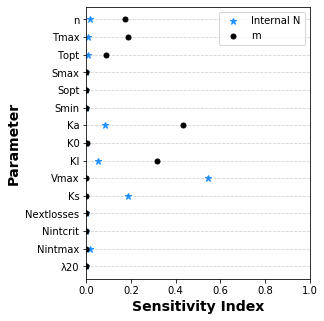

In [26]:
fig,ST2 = plt.subplots(1,1,sharex=True,figsize=(4,5))
#ST2.plot(Si3['ST'],problem['names'],'s',markersize=5,color='dimgray')
ST2.plot(Si2['ST'],problem['names'],'*',markersize=7,color='dodgerblue')
ST2.plot(Si1['ST'],problem['names'],'.',markersize=10,color='black')


ST2.set_xlabel('Sensitivity Index',fontsize=14, weight="bold")
ST2.set_ylabel('Parameter',fontsize=14, weight="bold")
ST2.set_xlim([0, 1])
ST2.set_axisbelow(True)
ST2.yaxis.grid(color='lightgray', linestyle='dashed')
ST2.legend(['Internal N','m'])


name = 'Offshore Sensitivity.png' 
fig.savefig(fname=name, dpi=600)

In [27]:
a = param_values.T

a

array([[1.87890625e-03, 2.48046875e-03, 1.87890625e-03, ...,
        2.64648437e-03, 2.64648437e-03, 2.64648437e-03],
       [4.09667969e+00, 4.09667969e+00, 4.71972656e+00, ...,
        4.65966797e+00, 4.65966797e+00, 4.65966797e+00],
       [1.99638672e+00, 1.99638672e+00, 1.99638672e+00, ...,
        1.79985352e+00, 1.79985352e+00, 1.79985352e+00],
       ...,
       [1.66113281e+01, 1.66113281e+01, 1.66113281e+01, ...,
        2.40966797e+01, 2.40966797e+01, 2.40966797e+01],
       [3.33027344e+01, 3.33027344e+01, 3.33027344e+01, ...,
        3.62646484e+01, 3.16240234e+01, 3.16240234e+01],
       [1.71777344e+00, 1.71777344e+00, 1.71777344e+00, ...,
        4.06884766e+00, 3.49755859e+00, 4.06884766e+00]])

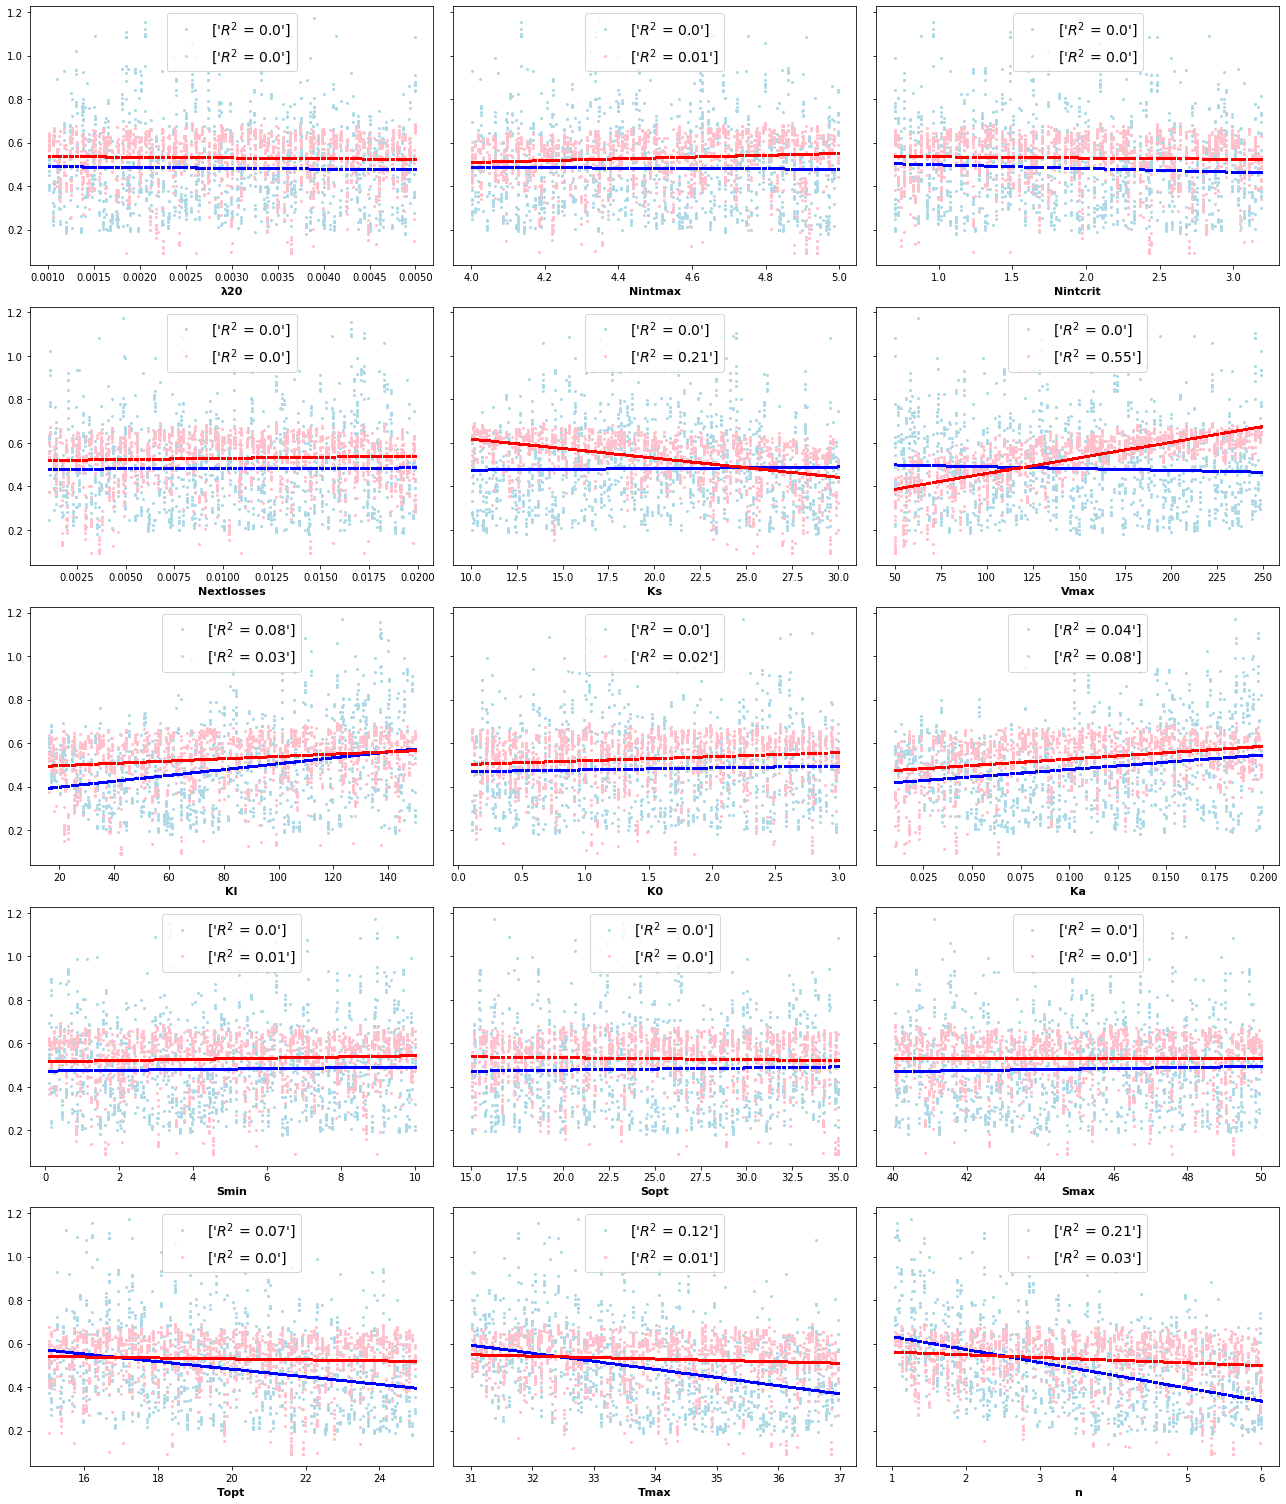

In [28]:
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])
    
        # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Offshore Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

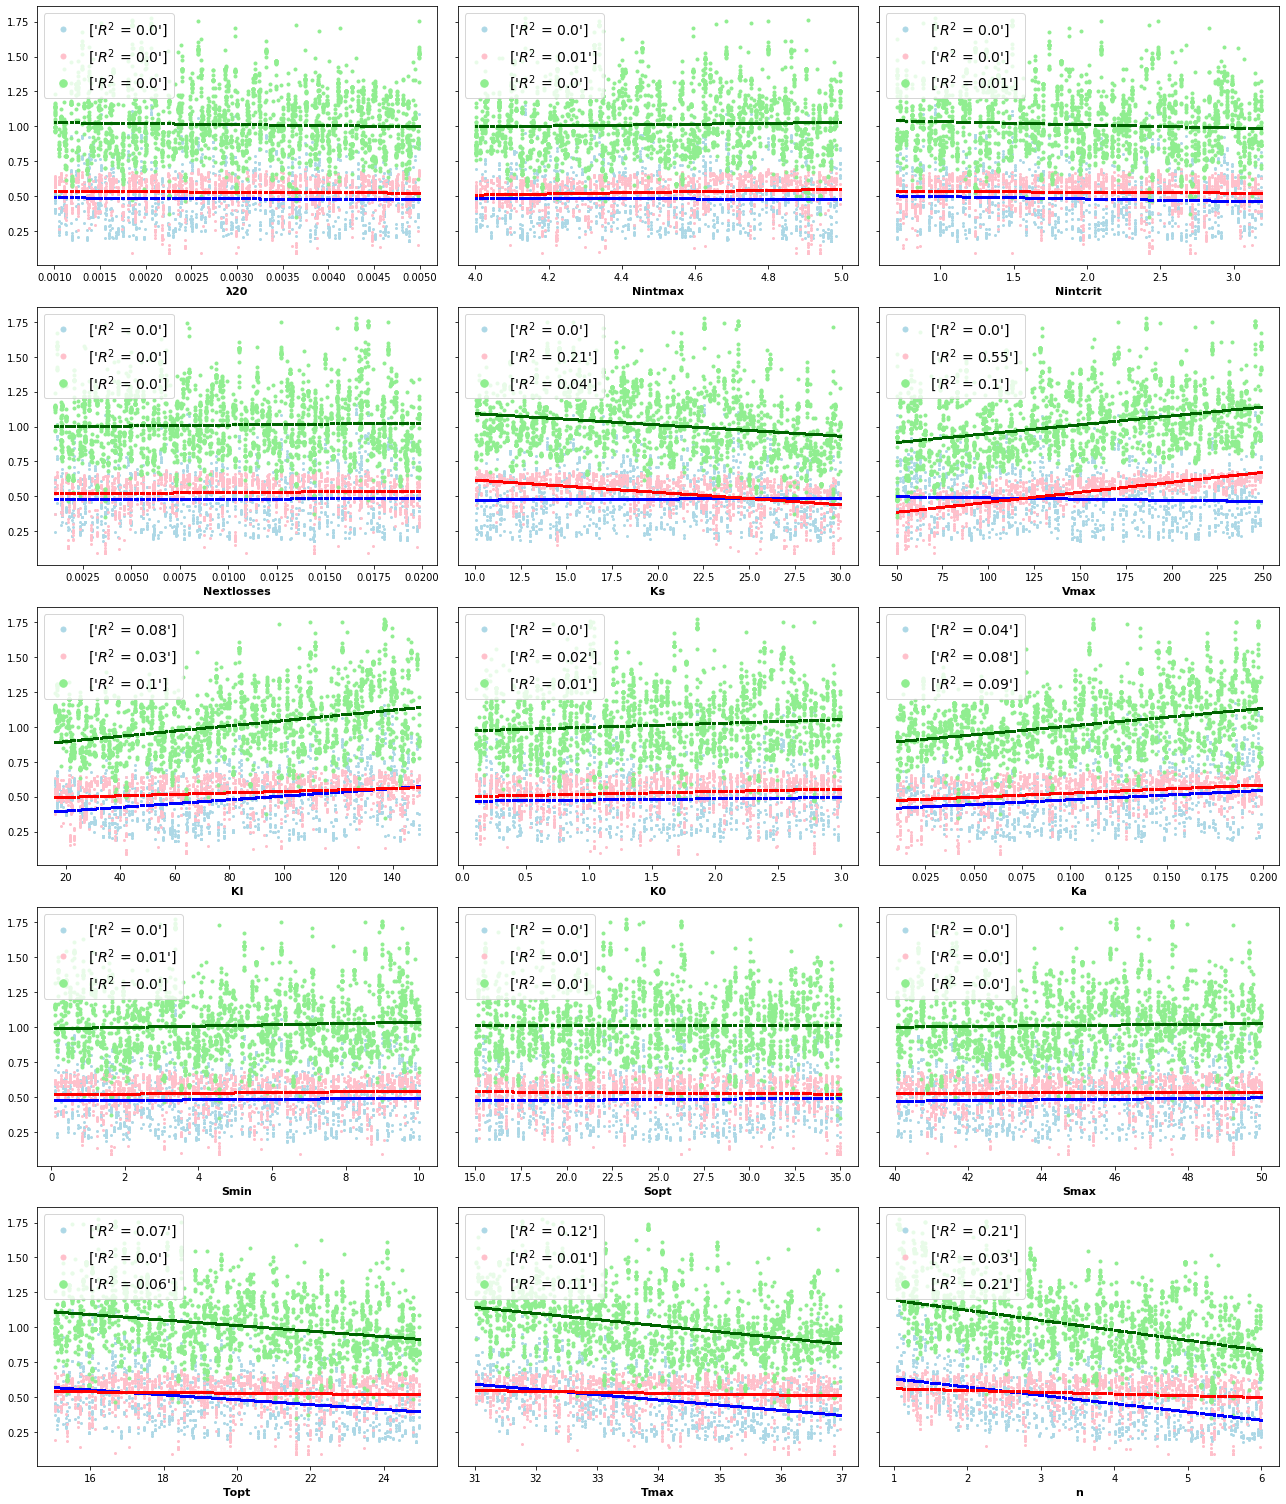

In [29]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Offshore Full Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

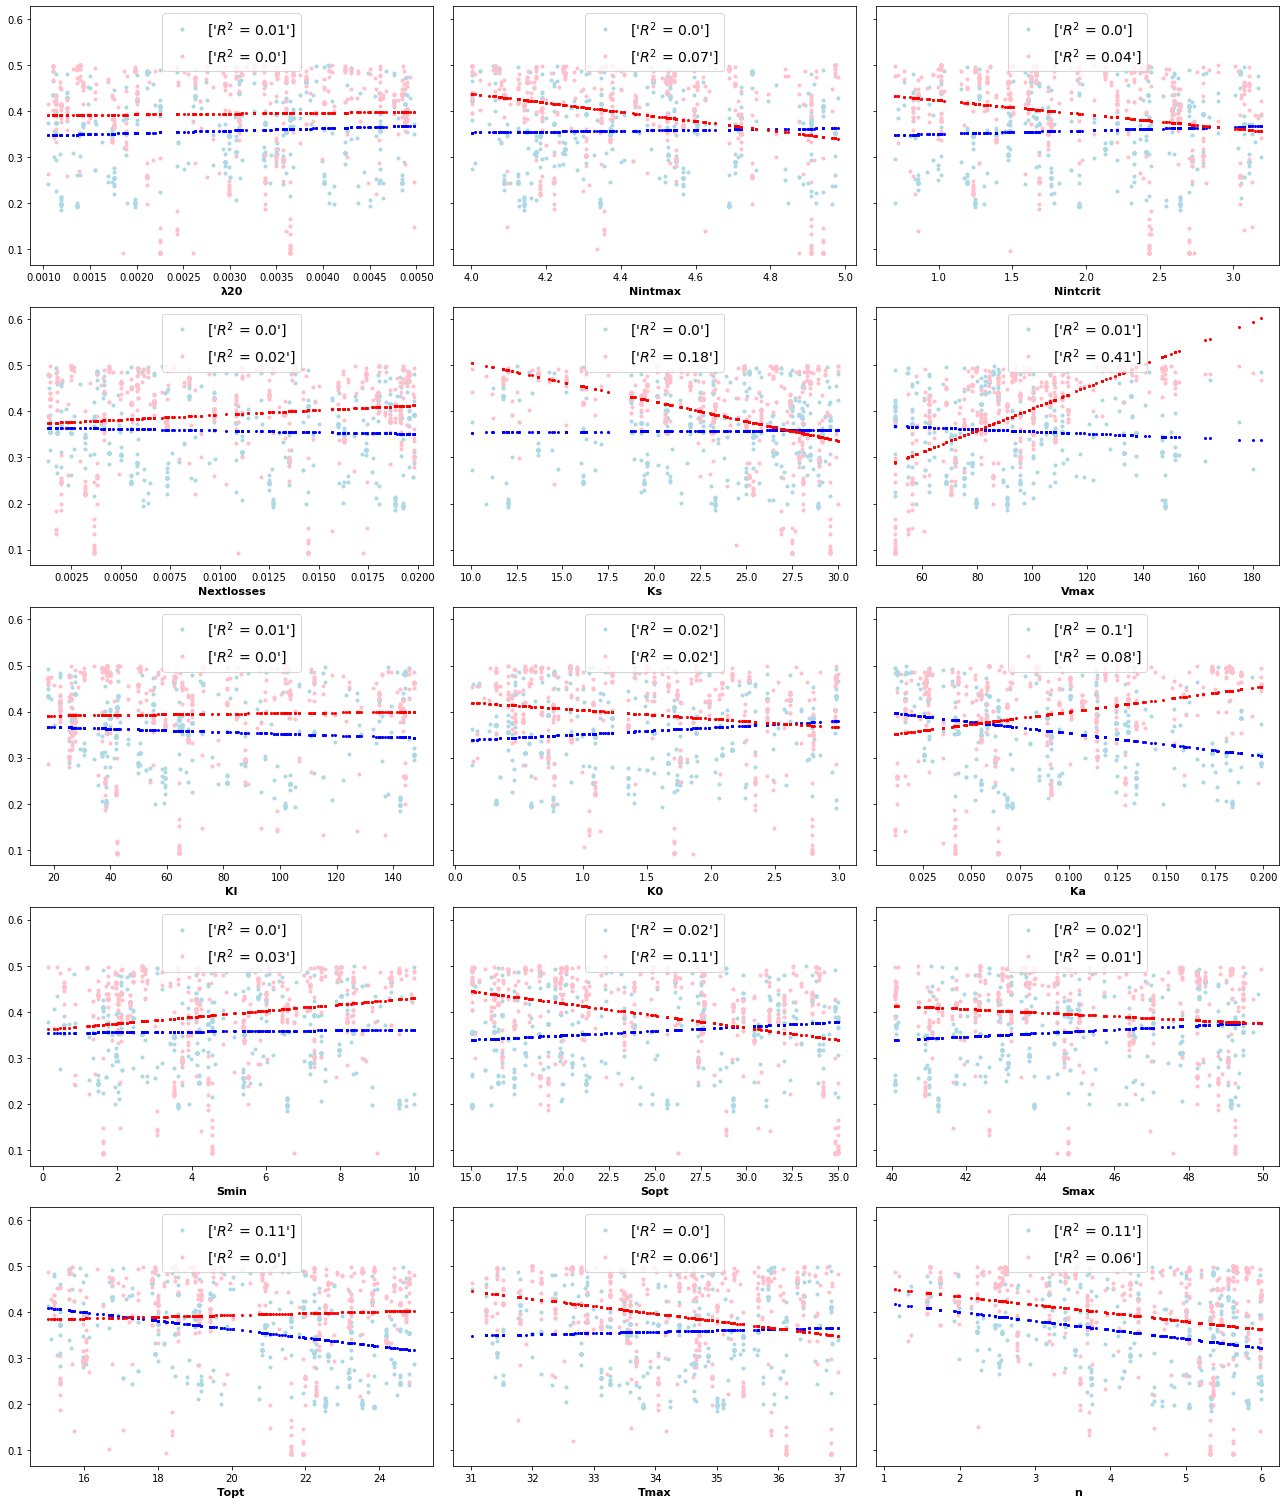

In [30]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.5) & (Y2[i] < 0.5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

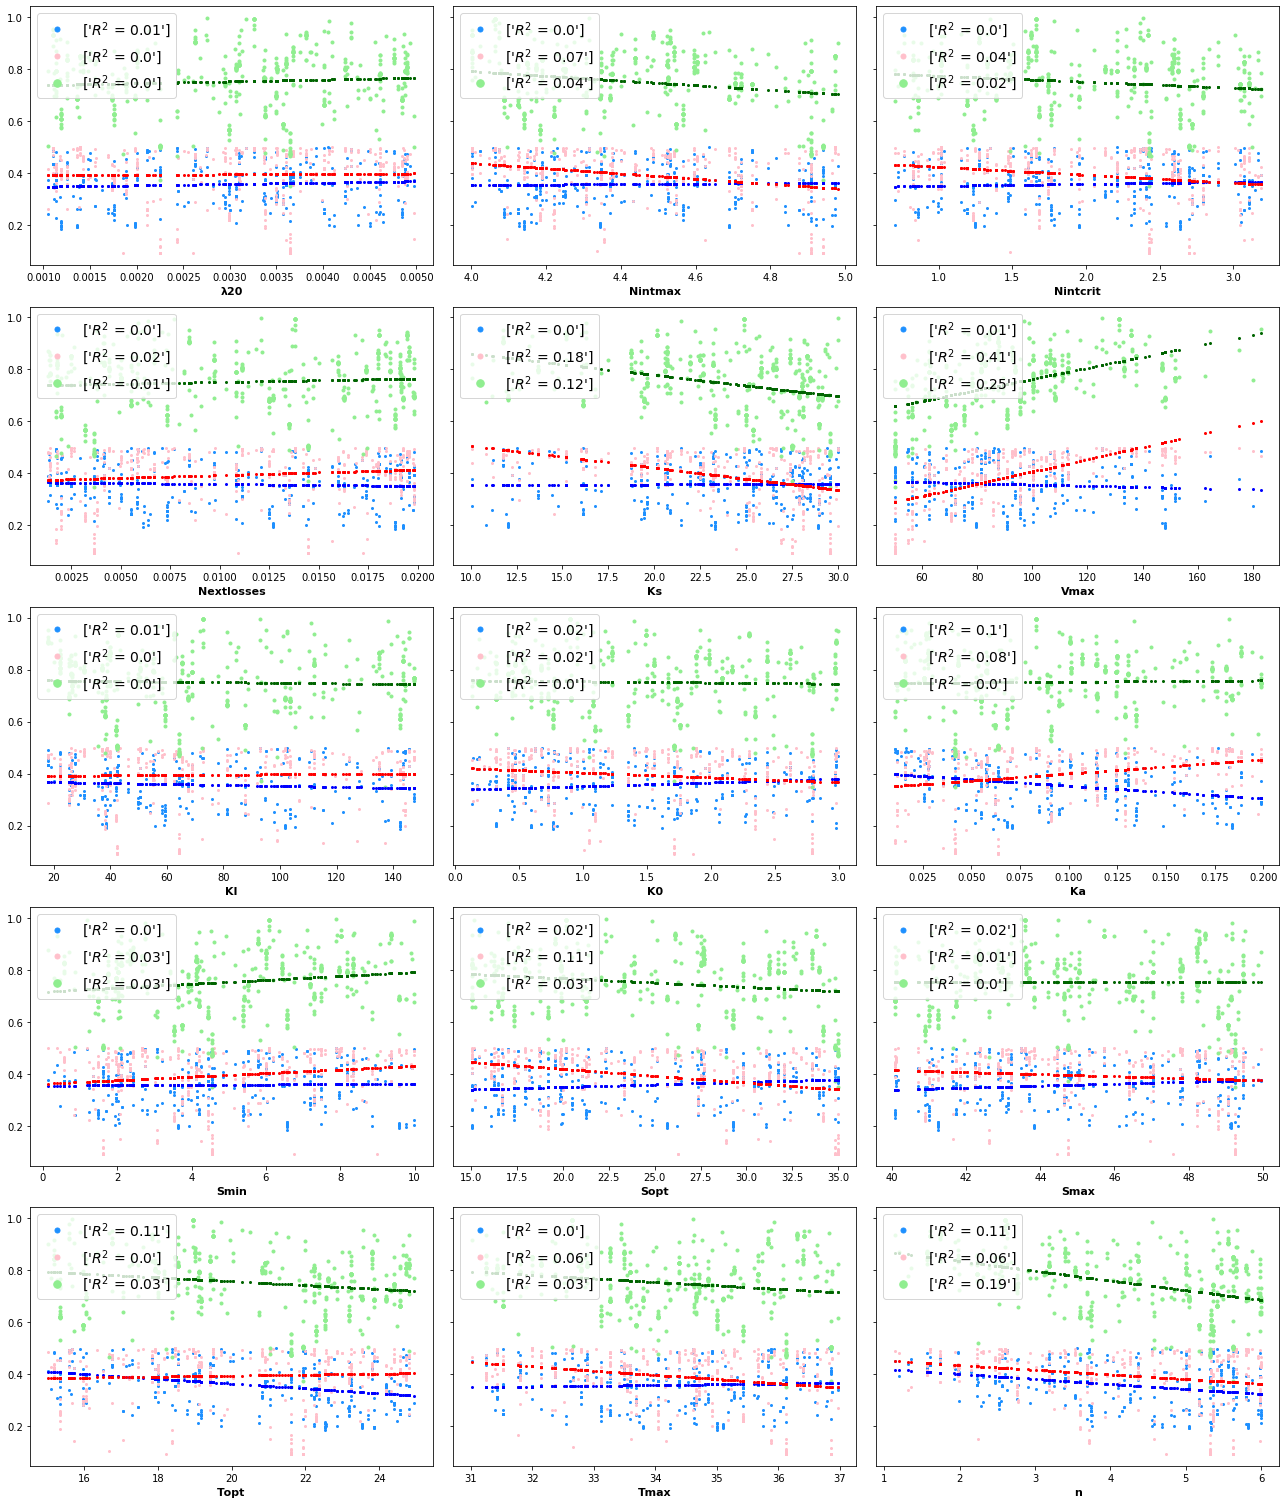

In [31]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.5) & (Y2[i] < 0.5):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'dodgerblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Offshore Error plots reduced.png' 
    
fig.savefig(fname=name, dpi=600)

In [32]:
dfP = pd.DataFrame(param_values[0:-1])
dfY1 = pd.DataFrame(Y1[0:-1])
dfY2 = pd.DataFrame(Y2[0:-1])
dfP.to_csv('Offshore_param_values.csv',index=False)
dfY1.to_csv('Offshore_Y1.csv',index=False)
dfY2.to_csv('Offshore_Y2.csv',index=False)

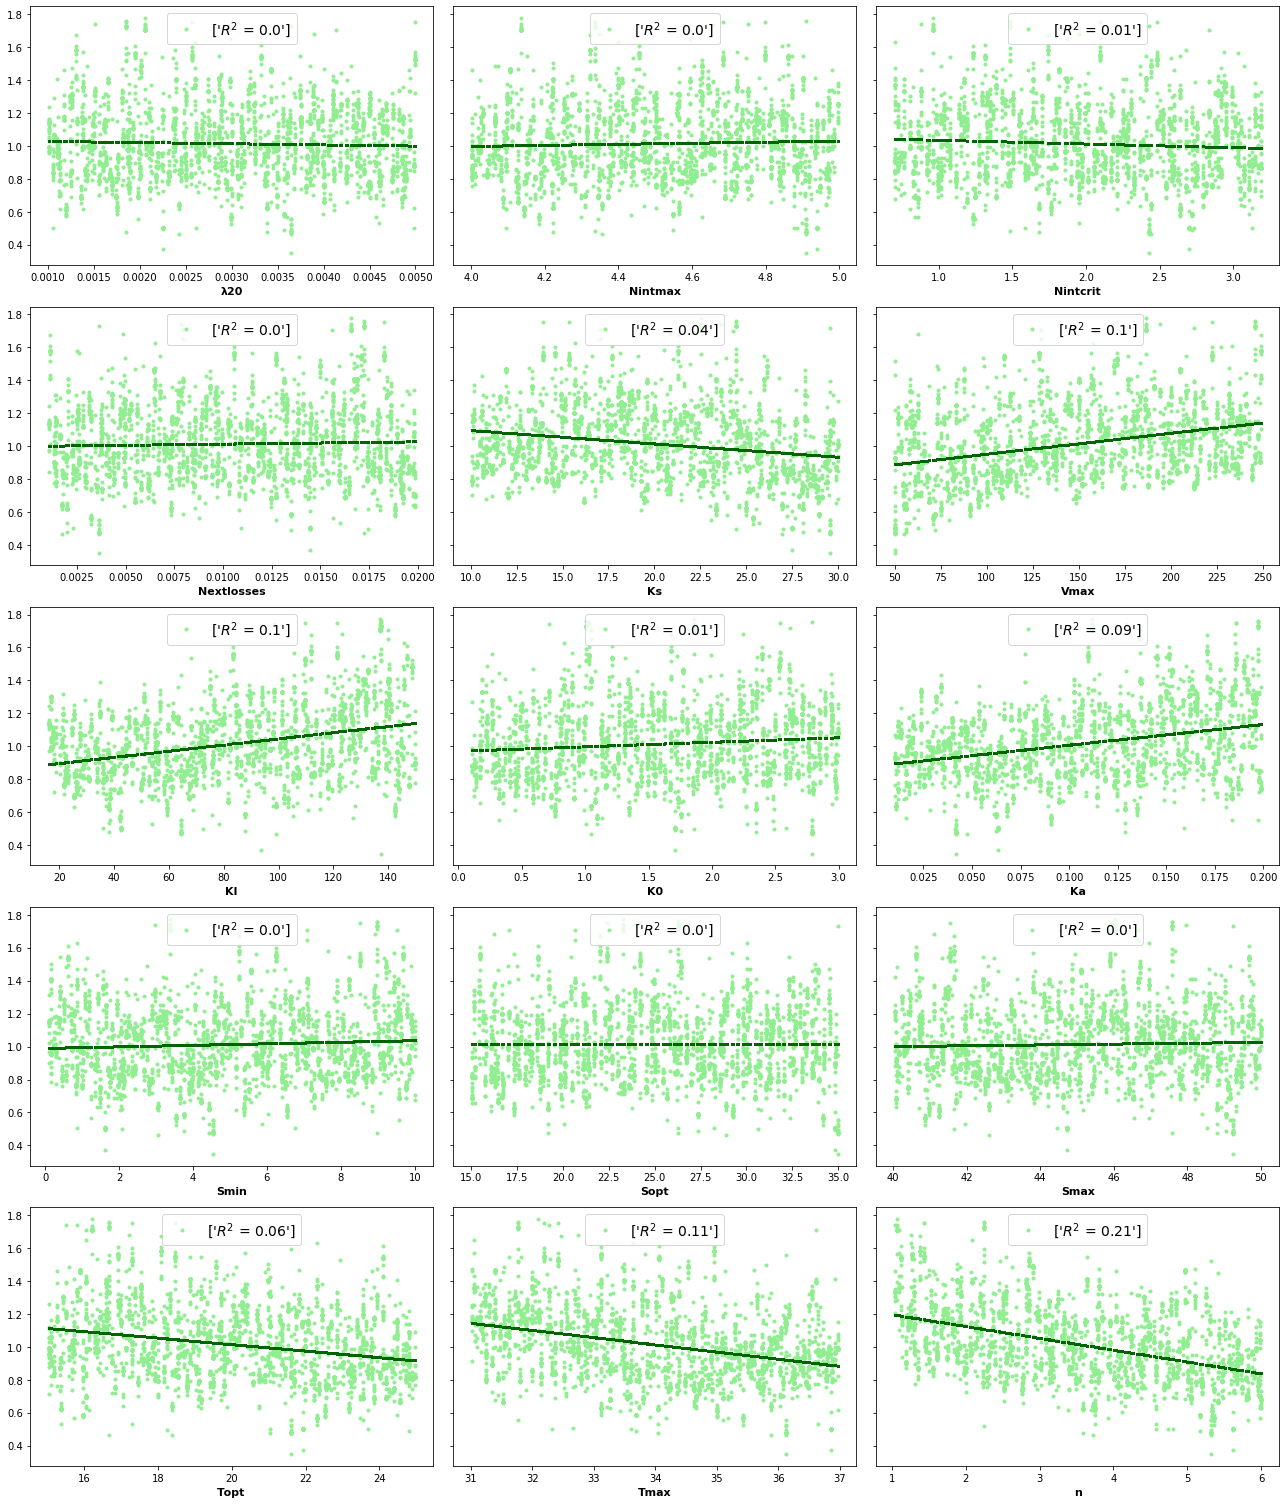

In [33]:
Y3 = Y1+Y2
Best_index = []
for i in range(len(Y3)):
    if (Y3[i] < 5):
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sq = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Offshor Combined Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

In [34]:

minerrorm = min(Y1)
minerrorN = min(Y2)
minsumerrors = min(Y3)

merror_best = Y1[Y3.tolist().index(min(Y3))]
Nerror_best = Y2[Y3.tolist().index(min(Y3))]

indminerrorm = Y1.tolist().index(min(Y1))
indminerrorN = Y2.tolist().index(min(Y2))
BestParam_m = param_values[Y1.tolist().index(min(Y1))]
BestParam_N = param_values[Y2.tolist().index(min(Y2))]
BestParam = param_values[Y3.tolist().index(min(Y3))]

print('Minimum error for m: ' + str(minerrorm))
print('Minimum error for Nint: ' + str(minerrorN) + '\n')
print('Minimum sum of errors: ' + str(minsumerrors) + '\n')
print('Best error for m: ' + str(merror_best))
print('Best error for N: ' + str(Nerror_best))

for i in range(len(problem['names'])):
    print('Parameter: ' + str(problem['names'][i]) + ' Best values: ' + str(round(BestParam_m[i],3)) + ' , ' +str(round(BestParam_N[i],3)) + ' and: ' +str(round(BestParam[i],3))+'\n')

Minimum error for m: 0.18
Minimum error for Nint: 0.092

Minimum sum of errors: 0.349

Best error for m: 0.216
Best error for N: 0.133
Parameter: λ20 Best values: 0.005 , 0.002 and: 0.004

Parameter: Nintmax Best values: 4.97 , 4.94 and: 4.91

Parameter: Nintcrit Best values: 1.116 , 2.734 and: 2.425

Parameter: Nextlosses Best values: 0.014 , 0.014 and: 0.004

Parameter: Ks Best values: 13.018 , 27.48 and: 29.58

Parameter: Vmax Best values: 150.098 , 50.195 and: 50.293

Parameter: KI Best values: 61.077 , 42.29 and: 137.278

Parameter: K0 Best values: 0.625 , 1.711 and: 2.789

Parameter: Ka Best values: 0.136 , 0.064 and: 0.042

Parameter: Smin Best values: 6.401 , 1.631 and: 4.546

Parameter: Sopt Best values: 28.311 , 34.824 and: 34.971

Parameter: Smax Best values: 43.901 , 44.736 and: 49.243

Parameter: Topt Best values: 24.878 , 21.924 and: 21.597

Parameter: Tmax Best values: 36.218 , 36.865 and: 36.124

Parameter: n Best values: 4.005 , 5.624 and: 5.319



In [35]:

minerrorm = min(Y1)
minerrorN = min(Y2)
minsumerrors = min(Y3)

merror_best = Y1[Y3.tolist().index(min(Y3))]
Nerror_best = Y2[Y3.tolist().index(min(Y3))]

indminerrorm = Y1.tolist().index(min(Y1))
indminerrorN = Y2.tolist().index(min(Y2))
BestParam_m = param_values[Y1.tolist().index(min(Y1))]
BestParam_N = param_values[Y2.tolist().index(min(Y2))]
BestParam = param_values[Y3.tolist().index(min(Y3))]

print('Minimum error for m: ' + str(minerrorm))
print('Minimum error for Nint: ' + str(minerrorN) + '\n')
print('Minimum sum of errors: ' + str(minsumerrors) + '\n')
print('Best error for m: ' + str(merror_best))
print('Best error for N: ' + str(Nerror_best))

for i in range(len(problem['names'])):
    print('Parameter: ' + str(problem['names'][i]) + ' Best values: ' + str(round(BestParam_m[i],3)) + ' , ' +str(round(BestParam_N[i],3)) + ' and: ' +str(round(BestParam[i],3))+'\n')

Minimum error for m: 0.18
Minimum error for Nint: 0.092

Minimum sum of errors: 0.349

Best error for m: 0.216
Best error for N: 0.133
Parameter: λ20 Best values: 0.005 , 0.002 and: 0.004

Parameter: Nintmax Best values: 4.97 , 4.94 and: 4.91

Parameter: Nintcrit Best values: 1.116 , 2.734 and: 2.425

Parameter: Nextlosses Best values: 0.014 , 0.014 and: 0.004

Parameter: Ks Best values: 13.018 , 27.48 and: 29.58

Parameter: Vmax Best values: 150.098 , 50.195 and: 50.293

Parameter: KI Best values: 61.077 , 42.29 and: 137.278

Parameter: K0 Best values: 0.625 , 1.711 and: 2.789

Parameter: Ka Best values: 0.136 , 0.064 and: 0.042

Parameter: Smin Best values: 6.401 , 1.631 and: 4.546

Parameter: Sopt Best values: 28.311 , 34.824 and: 34.971

Parameter: Smax Best values: 43.901 , 44.736 and: 49.243

Parameter: Topt Best values: 24.878 , 21.924 and: 21.597

Parameter: Tmax Best values: 36.218 , 36.865 and: 36.124

Parameter: n Best values: 4.005 , 5.624 and: 5.319

